# Stock Market Data and Analysis

This project aims to look at stock market data and form predictions based on a technical analysis. 

Resources:

https://github.com/venky14/Stock-Market-Analysis-and-Prediction/blob/master/Project-Stock%20Market%20Analysis%20and%20Prediction.ipynb

https://github.com/ratchahan/FinanceNotebook/blob/master/DataDrivenStockScreener.ipynb

https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7

In [1]:
import quandl
quandl.ApiConfig.api_key = 

In [2]:
#Data Processing
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import math

#Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
from datetime import datetime

For the purposes of this project, the Quandl API has been used. This is a free API, but does require an API key (available from their website). The Quandl API is accessible through pip and conda, and can call a range of financial data. 

For more information, please visit https://www.quandl.com/

Due to API limitations, we have decided to train data from 1 April 2017 to 1 April 2018. A further six months of data from 2018 will be tested on. 

In [4]:
tech_list = ['AAPL', 'MSFT', 'AMZN', 'GOOGL']
d = {}

start = pd.to_datetime('2017-04-01')
end = pd.to_datetime('2018-04-01')

for tech in tech_list:
    d[tech] = quandl.get('WIKI/'+str(tech), start_date=start, end_date=end)

We look at the Apple (AAPL) data as an example

In [5]:
d['AAPL'].head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2017-04-03,143.71,144.12,143.05,143.70,19985714.0,0.0,1.0,142.545929,142.952608,141.891275,142.536010,19985714.0
2017-04-04,143.25,144.89,143.17,144.77,19891354.0,0.0,1.0,142.089655,143.716370,142.010303,143.597342,19891354.0
2017-04-05,144.22,145.46,143.81,144.02,27717854.0,0.0,1.0,143.051798,144.281753,142.645119,142.853418,27717854.0
2017-04-06,144.29,144.52,143.45,143.66,21149034.0,0.0,1.0,143.121231,143.349367,142.288035,142.496334,21149034.0
2017-04-07,143.73,144.18,143.27,143.34,16658543.0,0.0,1.0,142.565767,143.012122,142.109493,142.178926,16658543.0


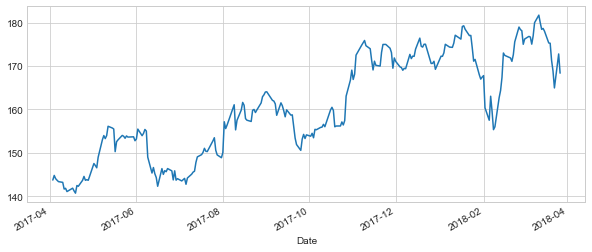

In [6]:
#Visualize the data by plotting the closing price for Apple
d['AAPL']['Close'].plot(label=True, figsize=(10,4))

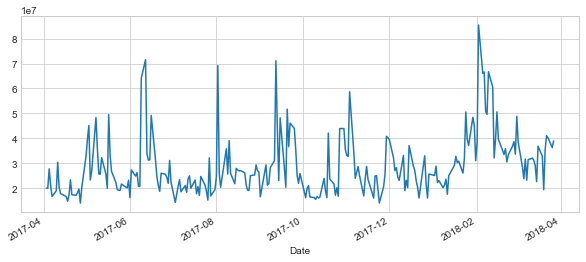

In [7]:
#Volume for Apple
d['AAPL']['Volume'].plot(label=True, figsize=(10,4))

## Technical Analysis

Technical indicators are mathematical tools which can be used to form conclusions about trends in stock market prices. These use past data trends to make future predictions (Folger, 2020). A trading strategy is a set of rules which a trader uses to make decisions about whether to buy, sell or hold stocks. Strategies are most effective when they combine the use of different types of indicators (Folger, 2020).

In this project, we write functions for the technical indicators, and visualise them using matplotlib.

### Moving Average
A moving average indicator uses historic data to show the trend in the price of a stock (Hayes, 2020). There are two types of moving averages: the simple moving average and the exponential moving average. The simple moving average computes the arithmetic mean of prices over the specified time period, whilst the exponential moving average computes a weighted mean, with more recent prices having a higher weight (Hayes, 2020). This results in an exponential moving average showing trends in the market sooner than a simple moving average. 

Changes in the concavity of moving average graphs can suggest when stocks have reached peaks and troughs. When a short-term moving average crosses above a long-term moving average, it suggests that the price of the stock may increase. Conversely, when a short-term moving average crosses below a long-term moving average, it suggests that the price of the stock may decrease (Hayes, 2020). 

In [8]:
#Moving Average Functions
def SMA(dataframe, period):
    SMA = pd.Series(dataframe['Close'].rolling(min_periods=1, center=True, window=period).mean(), name = 'SMA_' + str(period))
    dataframe = dataframe.join(SMA)
    return dataframe

def EMA(dataframe, period):
    EMA = pd.Series(dataframe['Close'].ewm(span=period, min_periods=1).mean(), name = 'EMA_' + str(period))
    dataframe = dataframe.join(EMA)
    return dataframe

In [9]:
periods = [10, 20, 50, 100]

In [10]:
#Simple Moving Average
for tech in tech_list:
    for n in periods:
        d[tech] = SMA(d[tech], n)

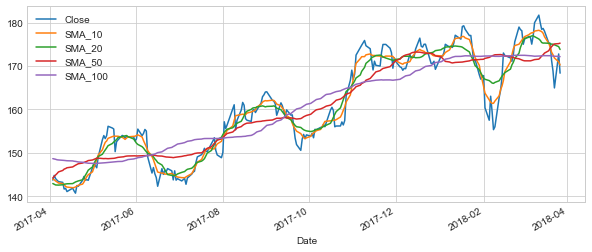

In [11]:
d['AAPL'][['Close', 'SMA_10', 'SMA_20', 'SMA_50', 'SMA_100']].plot(subplots=False, figsize=(10,4))

In [12]:
#Exponential Moving Average
for tech in tech_list:
    for n in periods:
         d[tech] = EMA(d[tech], n)

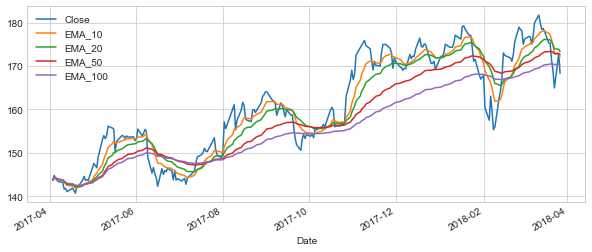

In [13]:
d['AAPL'][['Close', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_100']].plot(subplots=False, figsize=(10,4))

### Relative Strength Index
The relative strength index is a momentum indicator which can be used to show whether a stock is overbought or oversold (Chen, 2019). An RSI-value of 70 or more generally indicates that a share is overbought - the market value of the share is greater than its true value, and may decrease - whilst an RSI-value of less than 30 indicates that a share is oversold - its market value is less than its true value, and the price may increase. 

In [14]:
def RSI(df, period):
    close_df = df['Close']
    delta = close_df.diff()
    #The first row of delta will contain a null value. This must be deleted before it can be processed.
    delta = delta.dropna()
    
    #Split the gains and losses
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    r_up = up.rolling(min_periods=1, center=True, window=period).mean()
    r_dwn = down.rolling(min_periods=1, center=True, window=period).mean()
    
    RS = r_up/r_dwn
    RSI = pd.Series(100 - (100 / (1 + RS)), name ='RSI')
    
    df = df.join(RSI)
    return df

In [15]:
for tech in tech_list:
    d[tech] = RSI(d[tech], 14)

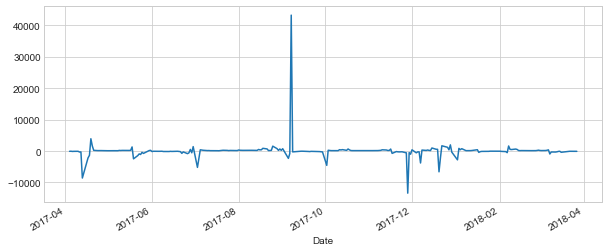

In [16]:
d['AAPL']['RSI'].plot(figsize=(10,4))

### Bollinger Bands
A bollinger band is an indicator which can show whether a stock is overbought or oversold. It consists of two lines, each two standard-deviation above the simple moving average (Hayes, 2019). These bands expand and contract depending on the risk associated with the market (Hayes, 2019). It is generally accepted that stocks are overbought when the prices are closer to the upper band, and oversold when prices are closer to the lower band (Hayes, 2019).

In [17]:
def bbands(df, win_size, num_stds):
    ma = df['Close'].rolling(min_periods=1, window=win_size).mean() #Simple Moving Average
    std = df['Close'].rolling(min_periods=1, window=win_size).std() #Standard Deviation
    
    upper = pd.Series(ma + (std*num_stds), name = 'Upper Band')
    lower = pd.Series(ma - (std*num_stds), name = 'Lower Band')
    middle = pd.Series(ma, name = 'BBand MA')
    
    df = df.join(upper)
    df = df.join(lower)
    df = df.join(middle)
    
    return df

In [18]:
for tech in tech_list:
    d[tech] = bbands(d[tech], 21, 2)

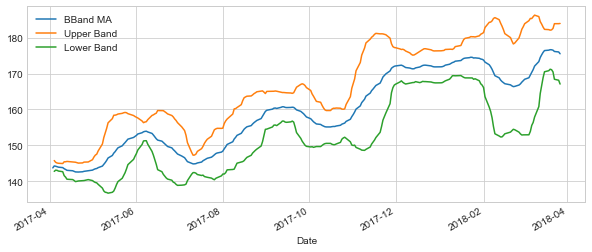

In [19]:
d['AAPL'][['BBand MA', 'Upper Band', 'Lower Band']].plot(subplots=False, figsize=(10,4))

### Moving Average Convergence Divergence
The moving average convergence divergence indicator uses the 26-period exponential moving average and the 12-period exponential average to show the momentum of a stock (Hayes, 2019). In addition to this, the signal line - a 9-day exponential average of the moving average convergence divergence - can be plotted to show crossovers. Generally, a buy signal is generated when the moving average convergence divergence indicator crosses above the signal line, and a sell signal is generated when the moving average convergence divergence indicator crosses below the signal line (Hayes, 2019). 

In [20]:
def MACD(df, fast, slow):
    EMAfast = df['Close'].ewm(span=fast, min_periods=1).mean()
    EMAslow = df['Close'].ewm(span=slow, min_periods=1).mean()
    
    MACD = pd.Series(EMAfast - EMAslow, name = 'MACD')
    MACDsline = pd.Series(MACD.ewm(span=9, min_periods=1).mean(), name = 'MACD_signal')
    MACDdiff = pd.Series(MACD - MACDsline, name = 'MACD_difference')
    
    df = df.join(MACD)
    df = df.join(MACDsline)
    df = df.join(MACDdiff)
    
    return df

In [21]:
for tech in tech_list:
    d[tech] = MACD(d[tech], 12, 26)

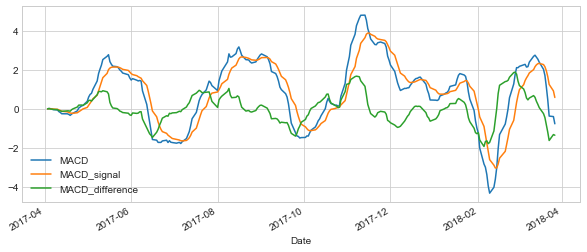

In [22]:
d['AAPL'][['MACD', 'MACD_signal', 'MACD_difference']].plot(subplots=False, figsize=(10,4))

### Stochastic Oscillator
Similarly to the relative strength index, the stochastic oscillator is a momentum indicator which can indicate whether a stock is overbought or oversold (Hayes, 2019). It compares the current closing price with the lowest and highest closing prices in a 14-day period. Generally, an overbought market has a stochastic oscillator greater than 80, and an oversold market has a stochastic oscillator less than 20. 


In [23]:
#Stochastic Oscillator %K
def STOK(df):
    SOk = pd.Series((df['Close'] - df['Low'])/(df['High'] - df['Low']), name = 'SO%k')
    df = df.join(SOk)
    return df

#Stochastic Oscillator %D
def STOD(df, n): 
    df = STOK(df)
    SOd = pd.Series(df['SO%k'].ewm(span=n, min_periods=1).mean(), name='SO%d')  
    df = df.join(SOd)
    return df

In [24]:
for tech in tech_list:
    d[tech] = STOD(d[tech], 14)

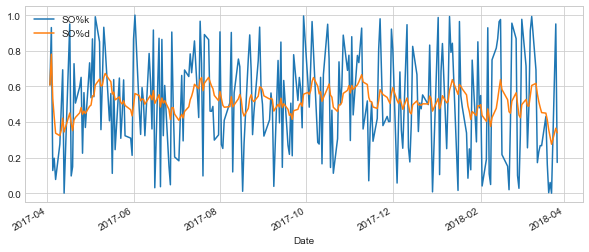

In [25]:
d['AAPL'][['SO%k', 'SO%d']].plot(subplots=False, figsize=(10,4))

## Return

Return is the measure of how the price of the stock changes on a day to day basis. It is caluclated using the following formula:
    
$$\frac{P_{t} - P_{t-1}}{P_{t-1}}$$

In [26]:
def returns(df):
    rets = pd.Series(df['Close']/(df['Close'].shift(1)-1), name = 'Return')
    df = df.join(rets)
    return df

In [27]:
for tech in tech_list:
    d[tech] = returns(d[tech])

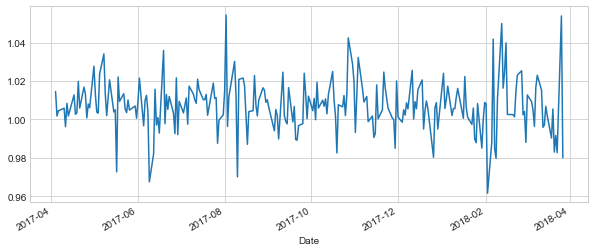

In [28]:
d['AAPL']['Return'].plot(figsize=(10,4))

We can also use seaborn to plot a histogram of the returns, along with the distribution

C:\Users\Jessica\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


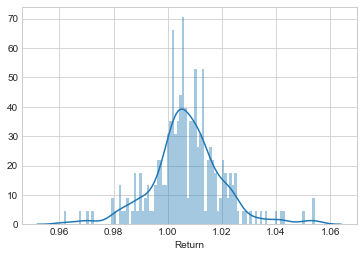

In [29]:
#We use dropna() as seaborn cannot read null values. 
sns.distplot(d['AAPL']['Return'].dropna(), bins=100)

## Correlation between stocks in the same industry

Using the returns calculated above, we analyse the correlation between stocks within the tech industry. 

The correlation is easily visualised using Seaborn. 

In [31]:
tech_returns = DataFrame()
closing_prices = DataFrame()
for tech in tech_list:
    tech_returns[tech] = d[tech]['Return']
    closing_prices[tech] = d[tech]['Close']


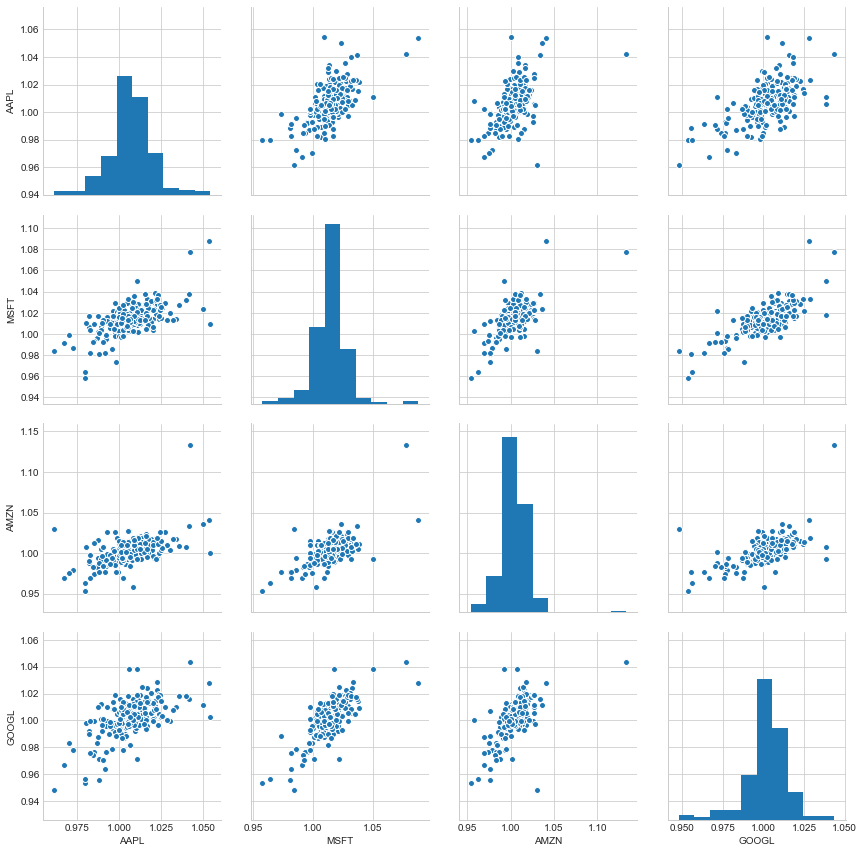

In [32]:
sns.pairplot(tech_returns.dropna(), size=3)

We can also visualise heatmaps of the correlation using Seaborn.

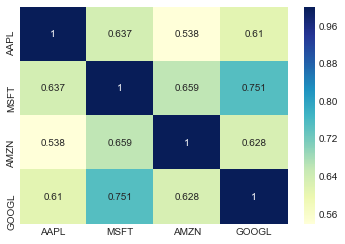

In [33]:
#Heatmap of the correlation between returns
sns.heatmap(tech_returns.corr(), annot=True, fmt='.3g', cmap='YlGnBu')

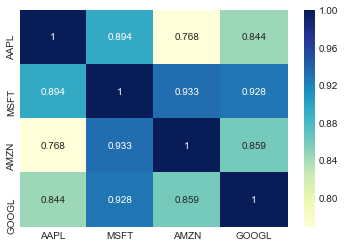

In [34]:
#Heatmap of the correlation between closing prices
sns.heatmap(closing_prices.corr(), annot=True, fmt='.3g', cmap='YlGnBu')

## Risk Analysis

Risk analysis can be done by looking at the probability distribution of the returns. This is because the standard deviation of the returns is a measure of risk. 

In this project, quartiles are used to suggest, with a certain level of confidence, the worst-case-senario amount of money one could expect to lose when investing in a stock. 

In [37]:
#This project works with a 99% confidence interval.
risks = {}
#Risk for Apple
for tech in tech_list:
    risks[tech] = d[tech]['Return'].dropna().quantile(0.01)

In [39]:
for tech in tech_list:
    print(f'If you were to invest $100 in {tech}, you would risk losing ${risks[tech] * 100}.')

If you were to invest $100 in AAPL, you would risk losing $97.12208274716299.
If you were to invest $100 in MSFT, you would risk losing $97.7023649946123.
If you were to invest $100 in AMZN, you would risk losing $96.56235201222685.
If you were to invest $100 in GOOGL, you would risk losing $95.59618099222456.


## Predicting Share Prices

This project uses linear and quadratic regression models to predict future stock prices. These are similar as they both use past data to form predictions. However, a linear regression model will return a straight line:
$$\hat{y} = A + Bx$$
whilst a quadratic regression model will return a curve. 

The SKLearn package contains a number of useful functions and machine learning algorithms. 

In [40]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbours import KNeighboursRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

ModuleNotFoundError: No module named 'sklearn.neighbours'

Before we can make predictions, we need to split and preprocess the data.

In [41]:
def NewFeatures(df):
    reg_df = df.loc[:,['Close', 'Volume']]
    reg_df['HL_PCT'] = (df['High']-df['Low'])/df['Close'] * 100
    reg_df['PCT_Change'] = (df['Close'] - df['Open'])/df['Open']
    return reg_df

In [47]:
def Process(df):
    df = df.fillna(value=-99999, inplace=True) #replaces all null values, which can't be processed in these models.
    
    #We are going to test on future data, so we do not need to remove data to forecast on. 
    
    forecast_col = 'Close'
    df['label'] = df[forecast_col]
    x = np.array(df.drop(['label'], 1))
    
    x = preprocessing.scale(x) #Preprocess X so that the distribution is uniform
    
    y = np.array(df['label'])
    
    return x, y

In [43]:
def Regression(x, y):
    clfreg = LinearRegression(n_jobs=-1)
    clfreg.fit(x,y)
    
    clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
    clfpoly2.fit(x,y)
    
    clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
    clfpoly3.fit(x,y)
    
    clfknn = KNeighboursRegressor(n_neighbours=2)
    clfknn,fit(x,y)

In [44]:
f = {}

start = pd.to_datetime('2018-04-01')
end = pd.to_datetime('2018-10-01')

for tech in tech_list:
    f[tech] = quandl.get('WIKI/'+str(tech), start_date=start, end_date=end)

We start with data from Apple

In [48]:
#Train the models
train_df = NewFeatures(d['AAPL'])
x_train, y_train = Process(train_df)

Regression(x_train, y_train)

#Test the models
test_df = NewFeatures(f['AAPL'])
x_test, y_test = Process(test_df)

confidencereg = clfreg.score(x_test, y_test)
confidencepoly2 = clfpoly2(x_test, y_test)
confidencepoly3 = clfpoly3(x_test, y_test)
confidenceknn = clfknn(x_test, y_test)

print(f'The confidence for the Linear Regression model is {confidencereg}')
print(f'The confidence for the Quadratic Regression 2-model is {confidencepoly2}')
print(f'The confidence for the Quadratic Regression 3-model is {confidencepoly3}')
print(f'The confidence for the K-Nearest Neighbours model is {confidenceknn}')

TypeError: 'NoneType' object is not subscriptable

In [ ]:
y_predict = clf.predict(x_test)
plt.figure(figsize=(10,4))
plt.plot(y_train, label='Training Data')
plt.plot(y_test, label='Actual Price')
plt.plot(y_predict, label='Predicted Price')
plt.title('Price of Apple Stocks')
plt.show()